In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

### 실습 과제 1. Boston_house_small 데이터를 활용한 PCA + regression 실습

#### 1) 데이터 불러온 후 train_data : test_data = 7:3 split, random_state=10
** 종속변수는 ‘Target', 독립변수는 나머지 변수

In [2]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('Boston_house_small.csv')

Input = df.drop('Target', axis = 1)
Output = df.loc[:, 'Target']

X_train, X_test, y_train, y_test = train_test_split(Input, Output, test_size = 0.3, random_state = 10)

print('train data : ', X_train.shape)
print('test data : ', X_test.shape)

train data :  (42, 13)
test data :  (18, 13)


#### 2) PCA 수행해서 주성분(principal component) 개수에 따른 mean squared Error 그래프 그리고, principal component 개수에 따른 PCA의 explained_variance_ratio 구하기
**cross_val_score 함수 이용해서(cv=5) principal component 5개까지 mean squared error 구하기
 

Explained variance per principal component: [0.4903983  0.10552172 0.08436537 0.07794373 0.06522836 0.05725848
 0.04260774 0.02852523 0.01583058 0.01303964 0.01268944 0.00498424
 0.00160716]


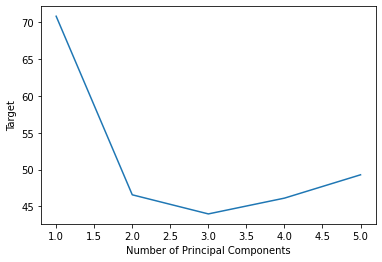

In [18]:
import warnings
warnings.filterwarnings(action='ignore')

pca = PCA()
mse = []
X_train_reduced = pca.fit_transform(scale(X_train))

reg = LinearRegression()
for i in np.arange(1,6):
    score = -1*cross_val_score(reg, X_train_reduced[:,:i], y_train, cv=5, scoring='neg_mean_squared_error').mean()
    mse.append(score)

num_pc = np.arange(1,6)
plt.plot(num_pc, mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('Target')

print('Explained variance per principal component: {}'.format(pca.explained_variance_ratio_))

#### 3) 가장 작은 mean squared error 가지는 주성분 개수로  PCA 수행하고, regression을 하기. 검증 데이터(test data)에 대한 mean squared error 구하고,  모델의 R^2 구하기

In [20]:
pca = PCA(n_components = 3)
X_train_reduced = pca.fit_transform(scale(X_train))
X_test_reduced = pca.transform(scale(X_test))

reg = LinearRegression()
reg.fit(X_train_reduced, y_train)

pred = reg.predict(X_test_reduced)

print('rmse: ', np.sqrt(mean_squared_error(y_test, pred)))
print('R^2: ', r2_score(y_test, pred))

rmse:  6.0355633179031285
R^2:  0.7305351279833862


#### 4)  PCA 없이 regression 하기. 검증 데이터(test data)에 대한 mean squared error 구하고,  모델이 R^2 구한 후 PCA를 수행한 결과와 비교하기

In [21]:
reg = LinearRegression()
reg.fit(X_train, y_train)

pred = reg.predict(X_test)

print('rmse: ', np.sqrt(mean_squared_error(y_test, pred)))
print('R^2: ', r2_score(y_test, pred))

rmse:  6.839887639217197
R^2:  0.6539295864346192


- PCA를 수행한 모델이 R^2 값 이 더 높다

### 실습 과제 2. Iris 데이터를 활용한 PCA + SVM 실습

#### 1) 데이터 불러온 후 train_data : test_data = 7:3 split, random_state=100
** 종속변수는 ‘Target', 독립변수는 나머지 변수

In [23]:
df = pd.read_csv('Iris.csv')

X = df.drop('Species', axis = 1)
y = df.loc[:, 'Species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

print('train data : ', X_train.shape)
print('test data : ', X_test.shape)

train data :  (105, 4)
test data :  (45, 4)


#### 2) PCA 수행해서 주성분(principal component) 개수에 따른 accuracy그래프 그리기
**cross_val_score 함수 이용해서(cv=5) principal component 5개까지 accuracy 구하기

Text(0, 0.5, 'accuracy')

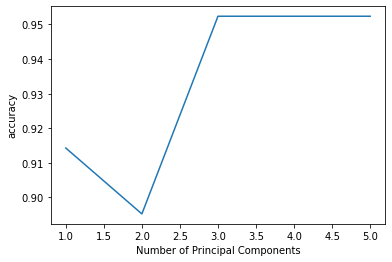

In [32]:
from sklearn import svm

pca = PCA()
accuracy = []
X_train_reduced = pca.fit_transform(scale(X_train))

for i in np.arange(1,6):
    score = cross_val_score(svm.SVC(), X_train_reduced[:,:i], y_train, cv=5, scoring='accuracy').mean()
    accuracy.append(score)

num_pc = np.arange(1,6)
plt.plot(num_pc, accuracy)
plt.xlabel('Number of Principal Components')
plt.ylabel('accuracy')

#### 3) 높은 accuracy 가지는 주성분 개수로 PCA 수행하고, 5-fold 교차 검증으로 SVM의 최적 하이퍼파라미터 구하기. 검증 데이터(test data)에 대한 최적 모델의 accuracy와 confusion matrix 구하기
** C: [0.01, 0.1, 0.5, 1, 10, 100], gamma: [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001], kernel: ['rbf', 'poly', 'linear']

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

pca = PCA(n_components = 3)

X_train_reduced = pca.fit_transform(scale(X_train))
X_test_reduced = pca.transform(scale(X_test))

param_grid = {'C':[0.01, 0.1, 0.5, 1, 10, 100],
              'gamma':[1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001],
              'kernel':['rbf', 'poly', 'linear']}
grid = GridSearchCV(svm.SVC(), param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train_reduced, y_train)

best_params = grid.best_params_
print(f"Best params: {best_params}")

best_svm = grid.best_estimator_

y_pred = best_svm.predict(X_test_reduced)

con_mat = metrics.confusion_matrix(y_test, y_pred)
acc_lin = metrics.accuracy_score(y_test, y_pred)

print('accuracy:', acc_lin)
print('='*30)
print('confusion mat : ')
print(con_mat)

Best params: {'C': 0.5, 'gamma': 1, 'kernel': 'linear'}
accuracy: 0.9333333333333333
confusion mat : 
[[16  0  0]
 [ 0 11  0]
 [ 0  3 15]]


#### 4) PCA 없이 최적 하이퍼파라미터로 SVM 모델 학습하기 , 검증 데이터(test data)에 대한 accuracy와 confusion matrix 구하기

In [45]:
non_pca_svm = svm.SVC(kernel='linear', C=0.5, gamma=1)
non_pca_svm.fit(X_train, y_train)

y_pred = non_pca_svm.predict(X_test)

con_mat = metrics.confusion_matrix(y_test, y_pred)
acc_lin = metrics.accuracy_score(y_test, y_pred)

print('accuracy:', acc_lin)
print('='*30)
print('confusion mat : ')
print(con_mat)

accuracy: 1.0
confusion mat : 
[[16  0  0]
 [ 0 11  0]
 [ 0  0 18]]
